# Spotting SAT Test Unfairness - Analysing New York City High School Data

## Introduction

The purpose of this project is to explore the relationship between SAT scores and demographic factors in New York City (NYC) public high schools. The SAT test (i.e., Scholastic Aptitute Test), is a test for high school seniors in the U.S., who take it every year. It consists of three sections, worth `800` points each. This test is used to determine which students to admit to high school. Usually, high average SAT scores are indicative of a good school. Since New York City has a very diverse population, comparing multiple demographics such as race, income, and gender is a good way to check whether the SAT test is fair or not.

We'll perform our analysis by combining multiple datasets into a single, clean pandas dataframe. We will then start analysing the data by creating correlations. We eventually found out that:
- Safety scores by students and teachers are indicators of high SAT scores.
- Races - white/ asian races could indicate high SAT scores, wheres black/ hispanic would indicate low SAT scores.
- Gender is not a very strong indicator of high SAT scores.
- There are exceptions to the races and gender indicators. These are schools with high technical funding and standardised admission criterias.

## Reading in the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
# Creating a list with all file names 
data_files = ["ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# creating an empty dictionary to store the files in order to be able to refer to them later on 
data = {} 

# initiating a for loop to read each file into a pandas dataframe and then store them into the dictionary 
for f in data_files:
    d = pd.read_csv("~/Desktop/my_projects/data/{0}".format(f)) # Retrieving files with their path
    data[f.replace(".csv", "")] = d # Using base of filenames as key 

## Exploring the SAT Data

The dataset we are more interested in is the SAT dataset as it contains the SAT scores for each high school in NYC. We will then correlate SAT information with information from other datasets.

In [3]:
# Explorig SAT results from the dataset data
print(data["sat_results"].head())

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

Based on this output, we can make a couple of observations: 
    
- The `DBN` is a unique ID for each school.
- We can see from the first few rows of names that we only have data about high schools.
- We only have a single row for each high school, so each `DBN` is unique in the SAT data.
- We will want to combine the three columns with SAT scores -- `SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score` -- into a single column to make the data easier to analyse.

Now, let's explore the data in a different dataset to see how we can combine them.

## Exploring the Remaining Data

In [4]:
for k in data: # Looping through each key in `data`
    print(data[k].head(5))

      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K     

Based on the first few rows of each dataset, we can make some observations:
- Each dataset has either a `DBN` column or the information we need to create one. This means that we can use the `DBN` column to combine the datasets. We will pinpoint matching rows from different datasets. We will do this by looking for identical `DBN`s. Then, we will group all f their columns together in a single dataset.
- `Location 1` looks like an interesting field for mapping. This field contains coordinates inside a larger string.
- Some datasets have many rows for each school (since the rows have duplicate `DBN` values). So we will have to do some preprocessing to make sure that each `DBN` is unique within each dataset. If we don't, we will run into problems when we combine the datasets. This will happen because we could be merging two rows in one data set with one row in another dataset.

## Reading in the Survey Data

In [5]:
# Reading in files with more complicated format
all_survey = pd.read_csv("~/Desktop/my_projects/data/survey_all.txt", delimiter="\t", encoding='windows-1252') # specifying rare encoding to prevent errors 
d75_survey = pd.read_csv("~/Desktop/my_projects/data/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# Combining the two files into a single dataframe
survey = pd.concat([all_survey, d75_survey], axis=0) 
survey = survey.copy()
print(survey.head())

      dbn    bn                      schoolname  d75 studentssurveyed  \
0  01M015  M015       P.S. 015 Roberto Clemente    0               No   
1  01M019  M019             P.S. 019 Asher Levy    0               No   
2  01M020  M020            P.S. 020 Anna Silver    0               No   
3  01M034  M034  P.S. 034 Franklin D. Roosevelt    0              Yes   
4  01M063  M063       P.S. 063 William McKinley    0               No   

   highschool                  schooltype  rr_s  rr_t  rr_p  ...  s_q14_2  \
0         0.0           Elementary School   NaN    88    60  ...      NaN   
1         0.0           Elementary School   NaN   100    60  ...      NaN   
2         0.0           Elementary School   NaN    88    73  ...      NaN   
3         0.0  Elementary / Middle School  89.0    73    50  ...      NaN   
4         0.0           Elementary School   NaN   100    60  ...      NaN   

   s_q14_3  s_q14_4  s_q14_5  s_q14_6  s_q14_7  s_q14_8  s_q14_9  s_q14_10  \
0      NaN      NaN 

Here's what we can immediately see from the data:
    
- There are over `2000` columns, all which we won't need. We will have to filter the data to remove the unnecessary ones so that we can print the dataframe and find correlations within it more easily.
- The survey data has a `dbn` column that we need to convert to uppercase (i.e., `DBN`) to make the column name consistent with the other datasets.

## Cleaning Up the Surveys

We will use the [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) to assess which columns to remove and which ones to keep.

In [6]:
# Converting column name to uppercase to keep consistency with other datasets
survey["DBN"] = survey["dbn"]

# Creating a list of the columns of survey_fields that are relevant to our analysis
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# Filtering survey so it only contains the columns listed above
survey = survey.loc[:,survey_fields]

# Assigning survey to the key survey in the dictionary data
data["survey"] = survey

# Exploring the data
print(survey.head())

      DBN  rr_s  rr_t  rr_p    N_s   N_t    N_p  saf_p_11  com_p_11  eng_p_11  \
0  01M015   NaN    88    60    NaN  22.0   90.0       8.5       7.6       7.5   
1  01M019   NaN   100    60    NaN  34.0  161.0       8.4       7.6       7.6   
2  01M020   NaN    88    73    NaN  42.0  367.0       8.9       8.3       8.3   
3  01M034  89.0    73    50  145.0  29.0  151.0       8.8       8.2       8.0   
4  01M063   NaN   100    60    NaN  23.0   90.0       8.7       7.9       8.1   

   ...  eng_t_11  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0  ...       7.6       7.9       NaN       NaN       NaN       NaN   
1  ...       8.9       9.1       NaN       NaN       NaN       NaN   
2  ...       6.8       7.5       NaN       NaN       NaN       NaN   
3  ...       6.8       7.8       6.2       5.9       6.5       7.4   
4  ...       7.8       8.1       NaN       NaN       NaN       NaN   

   saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11  
0         8.0         7.7         7.5   

## Inserting DBN Fields 

When we explored all of the datasets, we noticed that `class_size` does not have a `DBN` column.

In [7]:
print(data['class_size'].head(5))

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


Here below are the first few columns of `sat_results`, which have a `DBN` column.

In [8]:
# Exploring the data
print(data['sat_results'].head(5))

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

However, as shown above, the `DBN` column in the `sat_results` data is just a combination of the `CSD` and `SCHOOL CODE` column in the `class_size` data. The only difference is that the `DBN` is padded, so that `CSD` always consists of two digits. This means that if we add a leading `0` to the `CSD` that have only one digit, we will be able to combine the two columns and generate a `DBN` value for the `class_size` data too. 

In [9]:
# Creating a function to pad columns
def pad_csd(num): # Creating custom function that takes in a number 
    return str(num).zfill(2) # Converting the number to a string and checking the length of the string; if the string is two digits long, it returns the string. If the string is one digit long, it adds a `0` to the front of the string and then returns it

# Applying the function
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd) # Creating a new column to add a leading 0 to the csd that have only one digit.

# Merging padded_csd and `SCHOOL CODE` - using the addition operator (+)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
print(data['class_size'].head(5))

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


In [10]:
# Renaming column into uppercas letters for consistency
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

## Combining the SAT Scores

In [11]:
# Creating a list with the SAT scores for the different sections of the exam
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

# Converting column values from string to numeric to add columns together 
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors = "coerce") # Passing the keyword argument `errors='coerce'` so that pandas treats invalid strings as missing values

# Creating a column in sat_score that holds the combined SAT score for each student - this will make it easier to correlate scores with demographic factors 
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Displaying the first few rows to verify that everything went okay
print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


## Parsing Geographic Coordinates for Schools

In [12]:
# Parsing latitude and longitude coordinates for each school to map geographic patterns 
print(data['hs_directory']['Location 1'].head())

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object


### Exctracting the Latitude

In [13]:
# Creating a function to extract the latitude from fields which contain lots of unnecessary information
def find_lat(loc): 
    coords = re.findall("\(.+\)", loc) # Using a regex to extract the latitude
    lat = coords[0].split(",")[0].replace("(", "") # Using string manipulation functions to pull out latitude
    return lat 

# Applying the function using the apply() method 
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)

# Displaying the first few rows to verify results 
print(data['hs_directory'].head())

      dbn                                        school_name       boro  \
0  17K548                Brooklyn School for Music & Theatre   Brooklyn   
1  09X543                   High School for Violin and Dance      Bronx   
2  09X327        Comprehensive Model School Project M.S. 327      Bronx   
3  02M280     Manhattan Early College School for Advertising  Manhattan   
4  28Q680  Queens Gateway to Health Sciences Secondary Sc...     Queens   

  building_code    phone_number    fax_number grade_span_min  grade_span_max  \
0          K440    718-230-6250  718-230-6262              9              12   
1          X400    718-842-0687  718-589-9849              9              12   
2          X240    718-294-8111  718-294-8109              6              12   
3          M520  718-935-3477             NaN              9              10   
4          Q695    718-969-3155  718-969-3552              6              12   

  expgrade_span_min  expgrade_span_max  ...  \
0               NaN  

### Extracting the Longitude

Now we will do the same for the longitude.

In [14]:
# Creating a function to extract the longitude from fields which contain lots of unnecessary information
def find_lon(loc):
    coords = re.findall("\(.+\)", loc) # Using a regex to extract the longitude
    lon = coords[0].split(",")[1].replace(")", "").strip() # Using string manipulation functions to pull out longitude
    return lon

# Applying the function using the apply() method 
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

# Converting `lat` and `lon` columns to numbers
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors="coerce")
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors="coerce")

# Exploring the data
print(data['hs_directory'].head())

      dbn                                        school_name       boro  \
0  17K548                Brooklyn School for Music & Theatre   Brooklyn   
1  09X543                   High School for Violin and Dance      Bronx   
2  09X327        Comprehensive Model School Project M.S. 327      Bronx   
3  02M280     Manhattan Early College School for Advertising  Manhattan   
4  28Q680  Queens Gateway to Health Sciences Secondary Sc...     Queens   

  building_code    phone_number    fax_number grade_span_min  grade_span_max  \
0          K440    718-230-6250  718-230-6262              9              12   
1          X400    718-842-0687  718-589-9849              9              12   
2          X240    718-294-8111  718-294-8109              6              12   
3          M520  718-935-3477             NaN              9              10   
4          Q695    718-969-3155  718-969-3552              6              12   

  expgrade_span_min  expgrade_span_max  ...                       pr

## Combining the Data 

So far, we found that we can combine the datasets using the `DBN` column. However, before combining them, we need to condense some of the datasets in preparation for the merge. For instance, `class_size` has duplicate `DBN` values, which can cause issues if we don't condense them before the merge. A single row in `sat_results` could match many rows in `class_size`, and we don't know which one we should combine with the single matching entries. Let's condense `class_size`, `graduation`, and `demographics` so that each `DBN` in each dataset will be unique. 

In [15]:
# Exploring `class_size` further
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


`DBN` appears more than once because the first few rows all pertain to the same school. Moreover, each school has multiple values for `GRADE`, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)`, and `CORE COURSE (MS CORE and 9-12 ONLY)`. 

In [16]:
# Exploring column 'grade'
data['class_size']['GRADE '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

In [17]:
# Exploring column 'program type' 
data['class_size']['PROGRAM TYPE'].unique()

array(['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T'], dtype=object)

In [18]:
class_size = data['class_size']

# Picking high schools rows only
class_size = class_size[class_size['GRADE '] == '09-12'] # Adding space at the end of the name of the `'GRADE '` column to avoid generating errors 

# Selecting only the largest category of programs in each school
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']  

print(class_size.head())

     CSD BOROUGH SCHOOL CODE                                    SCHOOL NAME  \
225    1       M        M292  Henry Street School for International Studies   
226    1       M        M292  Henry Street School for International Studies   
227    1       M        M292  Henry Street School for International Studies   
228    1       M        M292  Henry Street School for International Studies   
229    1       M        M292  Henry Street School for International Studies   

    GRADE  PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
225  09-12       GEN ED                              ENGLISH   
226  09-12       GEN ED                              ENGLISH   
227  09-12       GEN ED                              ENGLISH   
228  09-12       GEN ED                              ENGLISH   
229  09-12       GEN ED                                 MATH   

    CORE COURSE (MS CORE and 9-12 ONLY) SERVICE CATEGORY(K-9* ONLY)  \
225                           English 9                           -  

### Computing Average Class Sizes

As shown above, `DBN` in `class_size` is still not completely unique. This is because of the values in the `CORE SUBJECT (MS CORE and 9-12 ONLY)` and `CORE COURSE (MS CORE and 9-12 ONLY)` columns. The two columns do not include all subjects and courses, however we want to include every single class. 

In [19]:
# Taking average across all classes of each school to get a unique 'DBN' value 
class_size = class_size.groupby('DBN').agg(np.mean) # Grouping class_size by DBN and calculating the average of each group 

# The DBN column became the index - correct by resetting the index to keep DBN as a column
class_size.reset_index(inplace=True) 

# Assigning the result back to class_size
data['class_size'] = class_size

# Displaying the first few rows to check that everything went okay
print(data['class_size'].head())

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292  1.0                            88.0000            4.000000   
1  01M332  1.0                            46.0000            2.000000   
2  01M378  1.0                            33.0000            1.000000   
3  01M448  1.0                           105.6875            4.750000   
4  01M450  1.0                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                   

### Condensing the Demographics Data Set

In [20]:
# Looking at the data
data['demographics']

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10070,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,20072008,85.6,NaN,355,NaN,NaN,NaN,NaN,...,151,42.5,198,55.8,5,1.4,181.0,51.0,174.0,49.0
10071,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,20082009,65.2,NaN,383,NaN,NaN,NaN,NaN,...,132,34.5,245,64.0,2,0.5,206.0,53.8,177.0,46.2
10072,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,20092010,,89.2,395,NaN,NaN,NaN,NaN,...,146,37.0,242,61.3,3,0.8,199.0,50.4,196.0,49.6
10073,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,20102011,,88.2,420,NaN,NaN,NaN,NaN,...,166,39.5,242,57.6,8,1.9,209.0,49.8,211.0,50.2


In [21]:
# Selecting rows where `schoolyear` is `20112012` so that we can have unique `DBN`s
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012] # `schoolyear` is an integer
print(data['demographics'].head())

       DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2  ...  \
6         NaN         89.4               189   13   31     35     28  ...   
13        NaN         61.5               328   32   46     52     54  ...   
20        NaN         92.5               626   52  102    121     87  ...   
27        NaN         99.7               401   14   34     38     36  ...   
35        NaN         78.9               176   18   20     30     21  ...   

   black_num black_per hispanic_num hispanic_per white_num white_per male_num  \

### Condensing the Graduation Data Set

In [22]:
data['graduation']

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,NaN,s,NaN,NaN,...,s,NaN,NaN,s,NaN,NaN,s,NaN,s,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25.0,37.2,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9.0,15.9,15,19.2,11,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25091,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2003,65,1,1.5,0,0.0,0.0,...,0,0.0,0.0,1,1.5,100.0,44.0,67.7,20.0,30.8
25092,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2004,64,2,3.1,0,0.0,0.0,...,0,0.0,0.0,2,3.1,100.0,38.0,59.4,22.0,34.4
25093,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2005,79,3,3.8,1,1.3,33.3,...,1,1.3,33.3,2,2.5,66.7,46.0,58.2,28.0,35.4
25094,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2006,57,4,7.0,2,3.5,50.0,...,2,3.5,50.0,2,3.5,50.0,34.0,59.6,17.0,29.8


In [23]:
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006'] # Selecting most recent cohort available
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort'] # Selecting total cohort from demographic to get unique `DBN`s
print(data['graduation'].head())

     Demographic     DBN                            School Name Cohort  \
3   Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   
10  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   2006   
17  Total Cohort  01M450             EAST SIDE COMMUNITY SCHOOL   2006   
24  Total Cohort  01M509                MARTA VALLE HIGH SCHOOL   2006   
31  Total Cohort  01M515  LOWER EAST SIDE PREPARATORY HIGH SCHO   2006   

    Total Cohort Total Grads - n  Total Grads - % of cohort Total Regents - n  \
3             78              43                       55.1                36   
10           124              53                       42.7                42   
17            90              70                       77.8                67   
24            84              47                       56.0                40   
31           193             105                       54.4                91   

    Total Regents - % of cohort  Total Regents - % of grads  ...  \


## Converting AP Test Scores 

The last task before combining all datasets is to convert the Advanced Placement (AP) test scores from string to numeric values. AP tests are exams that students take before applying to college, and they have a `1` to `5` scale and `3` or higher as a passing score. It is rarer to find AP exams in schools that luck funding or academic rigour. It would be interesting to discover if there is a correlation between AP exam scores and SAT scores. 

In [24]:
# Creating a list with the columns to convert
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

# Initiating a for loop
for col in cols: 
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors = "coerce") # converting values from string to numeric

# Exploring the data type after the changes 
print(data['ap_2010'].dtypes)

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


## Performing Left Joins

In [25]:
combined = data["sat_results"]

# Merging ap_2010 and graduation datasets with the sat_results datasets using a left join - since ap_2010 has lots of missing `DBN` values 
combined = combined.merge(data['ap_2010'], on='DBN', how='left') # Using `DBN` as the keyword argument to join the dataframes 
combined = combined.merge(data['graduation'], on='DBN', how='left') # Specifying 'left' as a keyword argument to indicate the correct join type 

# Displaying the first few rows to check that everything went okay
print(combined.head(5))

# Displaying how many rows exist now in the dataframe
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3                401.0      

In [26]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0


## Performing Inner Joins

In [27]:
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory'] # Listing all the datasets to merge

# Initiating a for loop to merge the datasets through an inner join - because the files contain more relevant info and have fewer missing `DBN` values 
for m in to_merge: 
    combined = combined.merge(data[m], on='DBN', how='inner') # Specifying the correct column to join on and the correct join type 
    
print(combined.head(5))
print(combined.shape)

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

## Filling in Missing Values 

We now have lots of columns with null values (i.e., `NaN`) because we used `left` joins. If we hadn't performed a `left` join, all of the rows with missing data would have been lost. This would not have left us with many high schools in our data set.

In [28]:
# Calculating means of all columns to fill in any missing value
combined = combined.fillna(combined.mean()) 

# Filling in any remaining missing values with 0
combined = combined.fillna(0) 

print(combined.head(5))

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

/var/folders/qs/fdrj_gks73v_3fn5zbpyl2000000gn/T/ipykernel_1173/2784157646.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


## Adding a School District Column for Mapping

Now we're done cleaning op our data! An interesting point to start our analysis from could be mapping the statistics out on a school district level. 

In [29]:
# Creating a function to get the school district 
def get_first_two_chars(dbn): # The school district is just the first two characters of DBN 
    return dbn[0:2]

# Applying the function
combined['school_dist'] = combined['DBN'].apply(get_first_two_chars)

print(combined['school_dist'].head())

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


# Analysing and Visualising the Data 

Now that we have combined all the datasets into a clean one, we are ready to perform our analysis.

## Finding Correlations With the r Value

In [30]:
# Looking for correlations between columns and the `sat_results` dataset
correlations = combined.corr() # using the corr() method to find all possible correlations
correlations = correlations['sat_score']

# Pretty-printing to display all rows and columns in the dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
Total Grads - % of cohort               0.584234
Total Regents - % of cohort             0.667603
Total Regents - % of grads              0.494732
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Regents w/o Advanced - % of cohort     -0.138188
Regents w/o Advanced - % of grads      -0.456213
Local - % of cohort                    -0.467951
Local - % of grads                     -0.494732
Still Enrolled - % of cohort           -0.491914
Dropped Out - % of cohort              -0.458537
CSD                                     0.042948
NUMBER OF STUDENTS /

With no surprise, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, and `SAT Writing Avg. Score` are strongly correlated to `sat_score`. 

Here are some other observations that we can make: 
- `total_enrollment` has a strong positive correlation with `sat_score`. This is an unexpected result as we would expect smaller schools where students would receive more attention to have higher scores. 
- Both the percentage of females (`female_per`) and the number of females (`female_num`) at a school correlate positively with `sat_Score`, whereas the same cannot be said about `male_per` and `male_sum`. This might indicate that women perform better at SAT scores than men.
- Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
- There is a correlation between student ratings of school academic standards (`aca_s_11`) and `sat_score`. However, this does not hold for ratings from teachers and parents (`aca_t_11`, and `aca_p_11`).
- There is a strong (positive) correlation between `white_per` and `asian_per` and `sat_score`. There is also a strong (negative) correlation between `black_per` and `hispanic_per` and `sat_score`. This could mean that there is strong racial inequality in SAT scores.
- There is a strong negative correlation between the percentage of students eligible for reduced school lunch based on household income (`frl_percent`) and `sat_score`.

### Plotting Enrollment With the Plot() Accessor

Since enrollment seems to have a strong correlation with SAT scores, let's make a scatterplot of `total_enrollment` vs `sat_score`. 

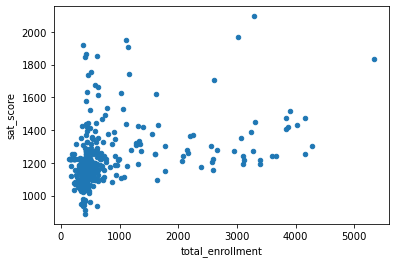

In [31]:
combined.plot.scatter(x="total_enrollment", y="sat_score") # using the pandas.DataFrame.plot() accessor on the dataframe
plt.show()

It doesn't look like there's a strong correlation between `sat_score` and `total_enrollment`. However, there is an interesting cluster where both `sat_score` and `total_enrollment` are low. This might be what is making the r value so high. It's worth extracting the names of the schools in this cluster so that we can investigate them more. 

In [47]:
low_enrollment = combined[combined['total_enrollment'] < 1000] # Filtering the dataframe to keep only relevant rows 
low_enrollment = low_enrollment[low_enrollment['sat_score'] < 1000] # Displaying all of the items in the School Name column of low_enrollment 
print(low_enrollment['School Name'])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


### Plotting Language Learning Percentage

It is believed that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This shows that it is actually `ell_percent` that is strongly correlated to `sat_score`, not `total_enrollment`. Let's plot out these two values to explore this relationship further.

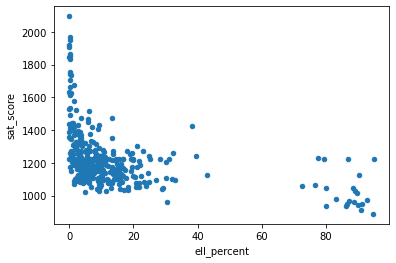

In [33]:
import matplotlib.pyplot as plt
combined.plot.scatter(x="ell_percent", y="sat_score")
plt.show()

### Calculating District-Level Statistics

Looking at the school-by-school variation makes it harder to analyse our data. One way to make it easier to read is to aggregate the data by district. 

In [48]:
import numpy

# Aggregating data to better understand how 'ell_percent' varies district-by-district
districts = combined.groupby('school_dist').agg(numpy.mean) # Grouping 'combined' by 'school_dist' and calculating the average of each group
districts.reset_index(inplace=True) # Resetting the index 

print(districts.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  \
0                            135.800000     93.

# Analysing the Data 

Now we have all the tools to analyse our data in greater depth. Let's start by plotting the correlation between survey fields and SAT scores.

## Plotting survey correlations

<AxesSubplot:>

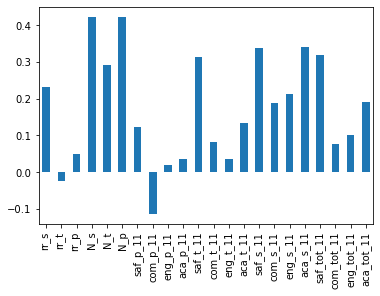

In [35]:
%matplotlib inline

# DBN is not a useful numerical value for correlation - fixing this by removing it
survey_fields.remove("DBN")

combined.corr()["sat_score"][survey_fields].plot.bar()

We can make some observations: 

- There is a strong positive correlation between `N_s`, `N_t`, `N_p` and `sat_score`. This might mean that the more the respondents, the more likely students will score high on the SAT test.

- The highest negative correlation is between `comp_p_11` and `sat_score`. This could mean that the less communication there is in the school, the lower the sat scores.
 
- There is a strong correlation between `saf_p_10` and `saf_t_10` and `sat_score`. The safer the environment at school is, the more likely students will be performing well. 
 
- There is a strong correlation between `aca_s_11` and `sat_score`. The way the student perceives the academic standards might have an impact on their test. Yet, this is not true for teachers nor parents' expectations. These scored low in correlation with `sat_score`.
 
- There is not a strong correlation between `eng_t_11` and `eng_p_11` and the `sat_score`. The less engaged teachers and parents are, the less likely students will score high in their test. But, there is a strong correlation between `eng_s_11` and the `sat_score`. This  means that more engaged students  will be more likely to score high.

## Exploring Safety and SAT Scores 

We discovered a strong correlation between how teachers perceive safety and SAT scores. Let's dig into this relationship a bit further to find out which schools have low safety scores.

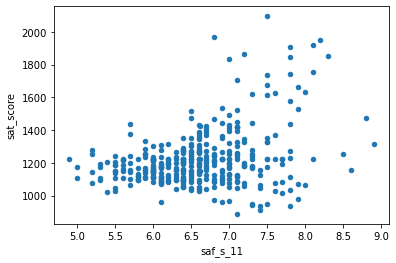

In [36]:
import matplotlib.pyplot as plt

# Creating a scatter plot with the values 
combined.plot.scatter(x='saf_s_11', y='sat_score')

plt.show()

Judging from the plot above, there is not a strong correlation. There's a large cluster of schools and a few others going off in three different directions. It looks like there are a few schools with high SAT scores and high safety scores. There are a few schools with low SAT scores and low safety scores. Finally, no 
school with safety scores lower than `6.5` has an average SAT score higher than `1500`.

Let's now calculate the average safety score for each borough to discover which borough has the lowest safet score in high schools.

### Borough Safety

In [37]:
# Computing average safety score for each borough 
boros = combined.groupby('boro').agg(numpy.mean)['saf_s_11']
print(boros)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


It looks like Manhattan and Queens have the highest average safety score, whereas Brooklyn has the lowest.

## Exploring Race and SAT Scores

Let's now explore the correlation between each race and the SAT scores to see if there are racial differences in SAT performance.

<AxesSubplot:>

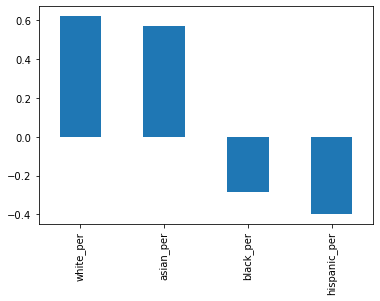

In [38]:
# Listing race fields 
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

# Making a bar plot of the correlations between race fields and SAT scores 
combined.corr()["sat_score"][race_fields].plot.bar()

There is a strong correlation between `sat_score` and white and asian races. This might mean that the SAT test is easier for these people to complete. Yet, there is a strong negative correlation between `sat_score` and `black_per` and `hispanic_per`. This might reinforce the argument that the SAT scores are designed in favour of white people. Let's explore schools with low SAT scores and high values for `hispanic_per`.

### Exploring Hispanic Demographics and SAT Scores

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

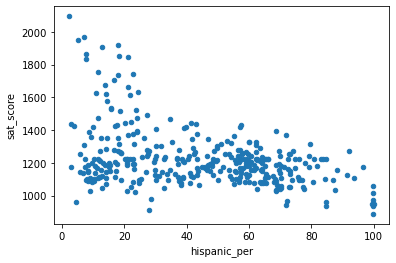

In [39]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

It looks like there is no strong correlation between `hispanic_per` and `sat_score`. There are a few schools where there is a low percentage of hispanic students and a high SAT score. Other few schools show a high amount of hispanic students and a low SAT score. There is also a cluster where the percentage of hispanic students is around `60` and the SAT score is around `1200`. Let's now research that cluster with a `hispanic_per` greater than `95%`. 

In [40]:
# Finding the school names in the data
print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed serve students who migrated to the U.S.. In these schools, students are learning English, which might explain why they scored low on their SAT tests.

In [41]:
# Researching schools with `hispanic_per` less than 10% and an avg SAT score greater than `1800`
print(combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools are specialised in science and technology. They receive extra fundings and only accept students who pass an entrance exam. Although this does not explain the low percentage of hispanic students, it says why their students tend to do better on the SAT exam. 

## Exploring Gender and SAT Scores

<AxesSubplot:>

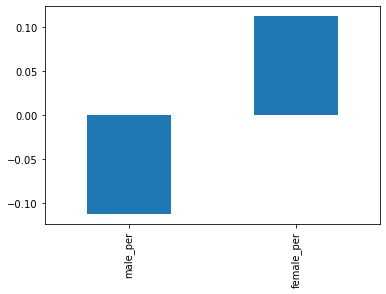

In [42]:
# Listing gender fields 
gender_fields = ['male_per', 'female_per']

combined.corr()["sat_score"][gender_fields].plot.bar()

There is a positive correlation between `female_per` and `sat_score` and a negative one between `male_per` and `sat_scores`. Female students are probably better than male students on SAT exams. 

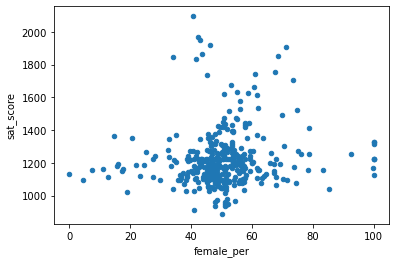

In [43]:
combined.plot.scatter(x='female_per', y='sat_score')
plt.show()

However, we did not find a correlation between schools with high percentage of female students and SAT scores. In fact, there are very few schools where there is a high percentage of female students and a low SAT score. There are also very few schools which have a medium amount of female students with very high scores.

Moreover, we found an interesting cluster where the majority of the schools have from `40%` to `60%` of female students who have a SAT score average of approximately `1200`.

In [44]:
# Finding school names in the data
print(combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It looks like these school are very selective liberal art schools which have high academic standards.

## Exploring AP Scores vs. SAT Scores

Let's now look at the percentage of students in each school who took at least one AP exam. Will we find a correlation with the SAT scores?

In [45]:
# Dividing the number of students who took the AP test by the `total_enrollment` column
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']) # Adding an extra space at the end of the `AP Test Takers ` column
print(combined['ap_per'])

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64


<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

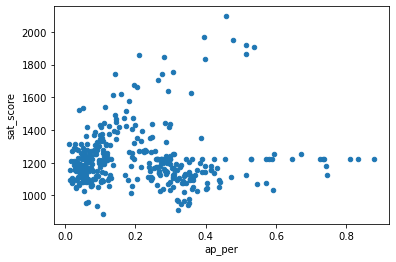

In [46]:
# Investigating the relationship between AP scores and SAT scores
combined.plot.scatter(x='ap_per', y='sat_score')

There is a weak correlation between students who took the AP test and the SAT score.

# Conclusions

In this project, we've explored the relationship between SAT scores and demographic factors in New York City (NYC) public high schools. Since New York City has a very diverse population, comparing multiple demographics such as race, income, and gender is a good way to check whether the SAT test is fair or not. We've performed our analysis by combining multiple datasets into a single, clean pandas dataframe. We then started analysing the data by creating correlations and plotting them. We eventually found out that:

- Safety scores by students and teachers are indicators of high SAT scores.
- White/ asian races could indicate high SAT scores, whereas black/ hispanic would indicate low SAT scores. 
- Gender is not a very strong indicator of high SAT scores.
- There are exceptions to the races and gender indicators. However, these are schools with high technical funding and standardised admission criterias. 

Despite our final conclusions, there's still quite a bit of analysis to do. For instance, we could try to determine whether there's a correlation between class size of SAT scores. Another question could be: "Which neighborhood has the best school?": we could try to answer this question by combining our current dataset with one that contains property values. In that way, we could find the least expensive neighborhoods that have good schools. Finally, it'd be interesting to investigate the differences between parents, teachers, and students responses to surveys. 